# Progetto Data Intensive Classificazione Income 
## Kyrillos Ntronov 0000830211
## Unibo - Cesena

# Descrizione Problema

- Il dataset utilizzato e' stato estratto dal database di censimento degli Stati Uniti (https://www.census.gov/),
contiene le informazioni anagrafiche e statistiche sulle persone. L'obiettivo del progetto consiste nel predire se una persona ha guadagno superiore a 50.000$ all'anno.

# Descrizione Variabili

- `age` | intero | eta' della persona.
- `workclass` | categorico {Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked} | tipo di datore di lavoro della persona.
- `fnlwgt` | intero | final weight, un valore calcolato dall'ufficio censimento per approssimare la quantita' di persone che il censimento rappresenta.
- `education` | categorico {Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool} | istruzione della persona.
- `education-num` | intero | education espresso come un intero da 1 a 16
- `marital-status` | categorico {Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse} | stato civile.
- `occupation` | categorico {Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces} | settore di lavoro della persona
- `relationship` | categorico {Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried} | relazione nello stato civile.
- `race` | categorico {White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black} | etnia.
- `sex` | categorico {Female, Male} | sesso.
- `capital-gain` | intero | aumento di capitale.
- `capital-loss` | intero | decremento di capitale.
- `hours-per-week` | intero | ore lavorative settimanali.
- `native-country` | categorico {United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands} | paese di nascita.

# Import e functions

In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

In [2]:
def pie_plot(x, **options):
    x.value_counts().sort_index().plot.pie(**options)
    print("total: {}\n{}".format(x.count(), x.value_counts()))
    
def class_val(x, mid):
    if x == 0:
        return "None"
    elif x < mid:
        return "Low"
    else:
        return "High"
    
def plot_correlation(dataset, sizeW, sizeH):
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(dataset, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(sizeW, sizeH))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(dataset, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
from scipy.stats import norm
from sklearn.metrics import accuracy_score

def conf_interval(a, N, Z=1.96):
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

def model_conf_interval(model, X, y, level=0.95):
    a = model.score(X, y)
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    return conf_interval(a, N, Z)

def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

def model_diff_interval(m1, m2, X, y, level=0.95):
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N, N, Z)


def print_c_i(model):
    lower, upper = model_conf_interval(model, X_test, y_test)
    print('Interval with confidence {}%: \nlower = {:.4f}\nupper = {:.4f}'.format(95, lower, upper))
    
def print_c_i_diff(model1, model2):
    lower, upper = model_diff_interval(model1, model2, X_test, y_test)
    print('Interval with confidence {}%: \nlower= {:.4f}\nupper = {:.4f}'.format(95, lower, upper))
    
def plot_best_feats(model, i):
    best_feats = pd.Series(model.best_estimator_[i].coef_[0], index=X_train.columns)
    best_feats.nlargest(4).plot(kind='barh')

def plot_confusion(model):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    f, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['<=50K', '>50K']); ax.yaxis.set_ticklabels(['<=50K', '>50K']);
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

# Pulizia Dati

- alcune colonne categoriche presentano dei dati con i valori inconsistenti, bisogna effettuare la pulizia

In [3]:
categorical = ["workclass", "education", "education-num", "marital-status",
               "occupation", "relationship", "race", "sex", "native-country", "income"];
dataset = pd.read_csv('income.csv', dtype={x:"category" for x in categorical}, skipinitialspace=True)

for x in categorical:
    dataset[x] = dataset[x].str.strip()
    dataset[x] = dataset[x].str.replace('.', '')

- Il dataset non contiene un valore id, si decide di crearlo

In [4]:
dataset.insert(0, 'id', range(1, 1 + len(dataset)))
dataset.set_index('id', inplace=True)

dataset.head()

age  workclass  fnlwgt   education education-num      marital-status  \
id                                                                         
1    27    Private  213921     HS-grad             9       Never-married   
2    40    Private   32214  Assoc-acdm            12  Married-civ-spouse   
3    67          ?  212759        10th             6  Married-civ-spouse   
4    18    Private  309634        11th             7       Never-married   
5    31  Local-gov  125927     7th-8th             4  Married-civ-spouse   

         occupation relationship   race     sex  capital-gain  capital-loss  \
id                                                                            
1     Other-service    Own-child  White    Male             0             0   
2      Adm-clerical      Husband  White    Male             0             0   
3                 ?      Husband  White    Male             0             0   
4     Other-service    Own-child  White  Female             0             0   
5   Farming-fishing      Husband  White    Male             0             0   

    hours-per-week native-country income  
id                                        
1               40         Mexico  <=50K  
2               40  United-States  <=50K  
3                2  United-States  <=50K  
4               22  United-States  <=50K  
5               40  United-States  <=50K

In [5]:
dataset.describe()

age        fnlwgt  capital-gain  capital-loss  hours-per-week
count  48692.000000  4.869200e+04  48692.000000  48692.000000    48692.000000
mean      38.646780  1.896459e+05   1079.917563     87.626612       40.420110
std       13.712711  1.056120e+05   7461.962840    403.303044       12.393256
min       17.000000  1.228500e+04      0.000000      0.000000        1.000000
25%       28.000000  1.175642e+05      0.000000      0.000000       40.000000
50%       37.000000  1.781350e+05      0.000000      0.000000       40.000000
75%       48.000000  2.375548e+05      0.000000      0.000000       45.000000
max       90.000000  1.490400e+06  99999.000000   4356.000000       99.000000

- Alcuni valori categorici non hanno un valore e sono stati segnati con "?", si decide di eliminare le righe con i valori mancancti e finalizzare le categorie

In [6]:
for x in categorical:
    dataset = dataset[dataset[x] != "?"]
    dataset[x] = dataset[x].astype('category')

dataset.describe()

age        fnlwgt  capital-gain  capital-loss  hours-per-week
count  45085.000000  4.508500e+04  45085.000000  45085.000000    45085.000000
mean      38.551558  1.897106e+05   1102.105090     88.707752       40.936209
std       13.219860  1.056400e+05   7516.210938    405.227465       12.008312
min       17.000000  1.349200e+04      0.000000      0.000000        1.000000
25%       28.000000  1.173930e+05      0.000000      0.000000       40.000000
50%       37.000000  1.783120e+05      0.000000      0.000000       40.000000
75%       47.000000  2.378680e+05      0.000000      0.000000       45.000000
max       90.000000  1.490400e+06  99999.000000   4356.000000       99.000000

- La quantita' di tuple perse e' accettabile

- Si esegue un controllo per le tuple con valore nullo

In [7]:
dataset.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

- Si riordina la categoria education nell'ordine logico del percorso scolastico

In [8]:
dataset['education'].cat.reorder_categories(['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th',
                                            '11th', '12th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc',
                                             'Some-college', 'Bachelors', 'Masters', 'Doctorate'], inplace=True)

- Infine, si decide di rimuovere l'attributo education-num in quanto ridondante e fnlwgt in quanto non e' pertinente all'analisi del problema

In [9]:
del dataset['education-num']
del dataset['fnlwgt']

# Analisi Esplorativa

- Si vuole analizzare la distribuzione della variabile da predire e il numero di istanze totale

total: 45085
<=50K    33911
>50K     11174
Name: income, dtype: int64


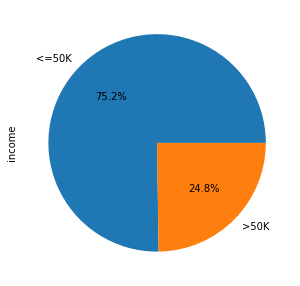

In [10]:
pie_plot(dataset['income'], labels=["<=50K", ">50K"], figsize=(5, 5), autopct='%1.1f%%')

- Si ha uno split di circa 75%/25% dei casi su 45085, sono sufficienti per ottenere un modello accettabile

- Si procede con la visualizzazione dei valori continui

Age - min: 17, max: 90, mean: 38.55155816790507
Hours Per Week - min: 1, max: 99, mean: 40.93620938227792
Capital Gain - min: 0, max: 99999, mean: 1102.1050903848286
Capital Loss - min: 0, max: 4356, mean: 88.70775202395475


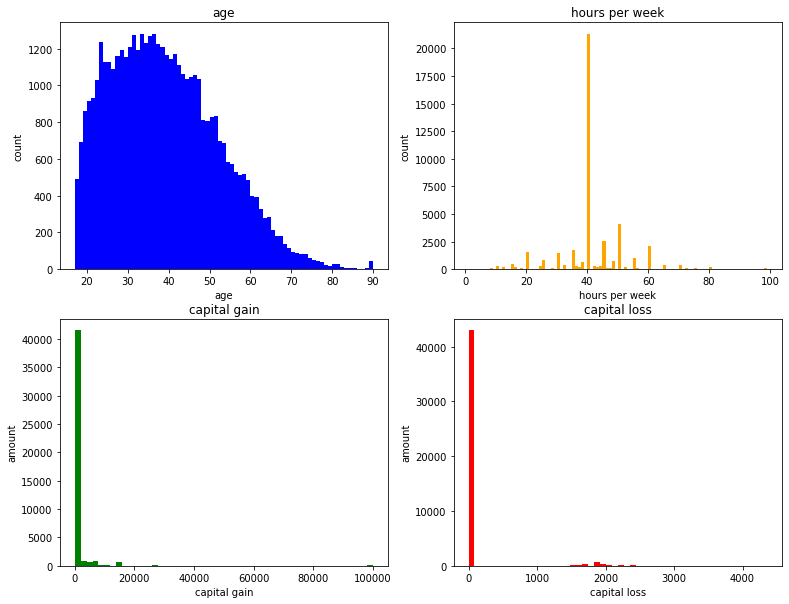

In [11]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.title('age')
plt.hist(dataset['age'], 73, label="age", color='blue')
plt.ylabel('count')
plt.xlabel('age')

plt.subplot(2, 3, 2)
plt.title('hours per week')
plt.hist(dataset['hours-per-week'], 98, label="hours", color='orange')
plt.ylabel('count')
plt.xlabel('hours per week')

plt.subplot(2, 3, 4)
plt.title('capital gain')
plt.hist(dataset['capital-gain'], 50, label="gain", color='green')
plt.ylabel('amount')
plt.xlabel('capital gain')

plt.subplot(2, 3, 5)
plt.title('capital loss')
plt.hist(dataset['capital-loss'], 50, label="loss", color='red')
plt.ylabel('amount')
plt.xlabel('capital loss')

print("Age - min: {}, max: {}, mean: {}".format(dataset['age'].min(), dataset['age'].max(), dataset['age'].mean()))
print("Hours Per Week - min: {}, max: {}, mean: {}".format(dataset['hours-per-week'].min(), dataset['hours-per-week'].max(), dataset['hours-per-week'].mean()))
print("Capital Gain - min: {}, max: {}, mean: {}".format(dataset['capital-gain'].min(), dataset['capital-gain'].max(), dataset['capital-gain'].mean()))
print("Capital Loss - min: {}, max: {}, mean: {}".format(dataset['capital-loss'].min(), dataset['capital-loss'].max(), dataset['capital-loss'].mean()))

- Dagli istogrammi si osserva che la maggior parte delle persone ha l'eta' compresa tra 17 e 50 anni, che prevedibilmente la settimana lavorativa media e' di 40 ore e che il guadagno e la perdita del capitale nella maggior parte dei casi sono prossimi a zero.

- Si procede con l'analisi delle variabili categoriche

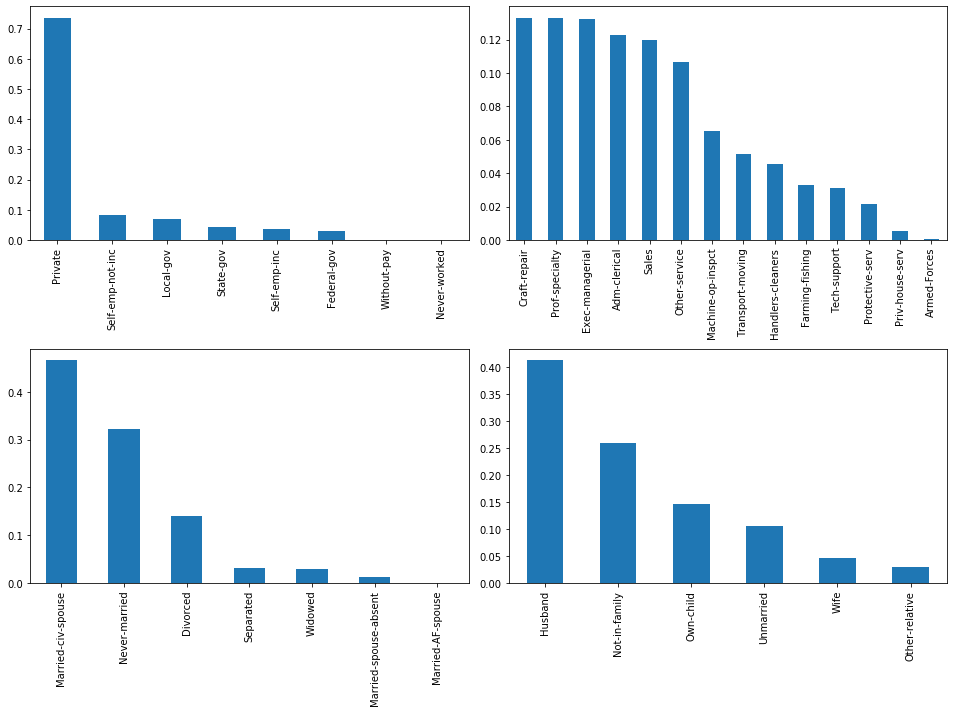

In [12]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
dataset['workclass'].value_counts(normalize = True).plot(kind='bar')

plt.subplot(2, 3, 2)
dataset['occupation'].value_counts(normalize = True).plot(kind='bar')

plt.subplot(2, 3, 4)
dataset['marital-status'].value_counts(normalize = True).plot(kind='bar')

plt.subplot(2, 3, 5)
dataset['relationship'].value_counts(normalize = True).plot(kind='bar')

plt.tight_layout()

- Vediamo che il tipo di occupazione principale e' il lavoro privato, mentre i settori di lavoro piu' frequenti sono quelli di artigianto/riparazione, professioni di specialta', direzione esecutiva, lavoro in ufficio e nelle vendite.

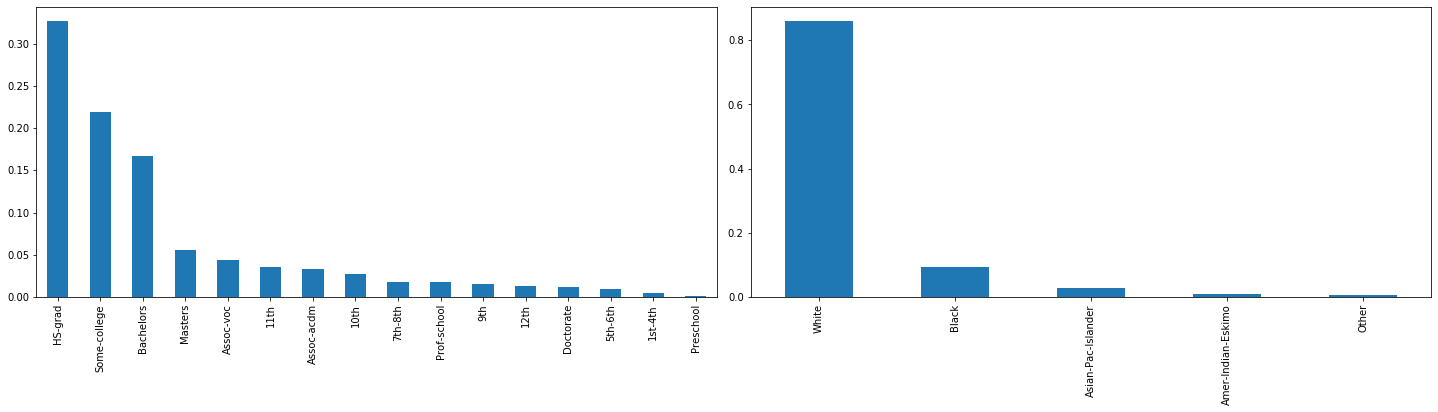

In [13]:
plt.figure(figsize=(30, 10))

plt.subplot(2, 3, 1)
dataset['education'].value_counts(normalize = True).plot(kind='bar')

plt.subplot(2, 3, 2)
dataset['race'].value_counts(normalize = True).plot(kind='bar')

plt.tight_layout()

- Possiamo osservare che l'istruzione piu' comune e' quella del diploma di scuola superiore, seguito dalla carriera universitaria incompleta e infine solamente circa il 16% ha la laurea breve

total: 45085
Male      30423
Female    14662
Name: sex, dtype: int64


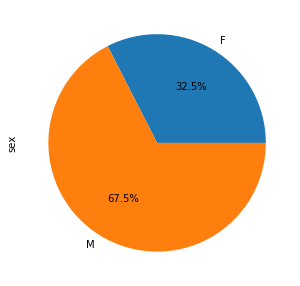

In [14]:
pie_plot(dataset['sex'], labels=["F", "M"], figsize=(5, 5), autopct='%1.1f%%')

- La distribuzione dei sessi non e' bilanciata.

Born in the US: 92%, Outside the US: 8%


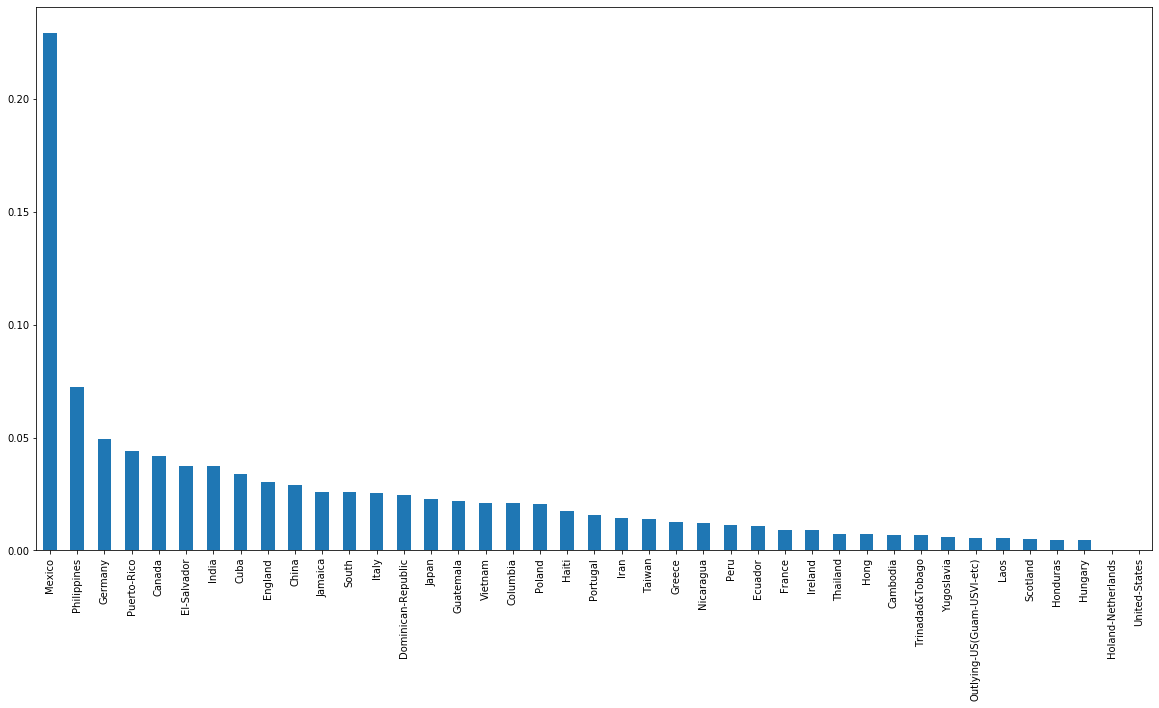

In [15]:
plt.figure(figsize=(20, 10))
dataset[dataset['native-country'] != "United-States"]['native-country'].value_counts(normalize = True).plot(kind='bar')

bi = dataset[dataset['native-country'] == "United-States"]['native-country'].count()
bo = dataset[dataset['native-country'] != "United-States"]['native-country'].count()
tot = bi + bo
print("Born in the US: {}%, Outside the US: {}%".format(math.ceil((bi / tot) * 100), math.floor((bo / tot) * 100)))

- Si osserva che la nazione di nascita piu' frequente, escludendo l'America, e' il Messico con circa 24%.

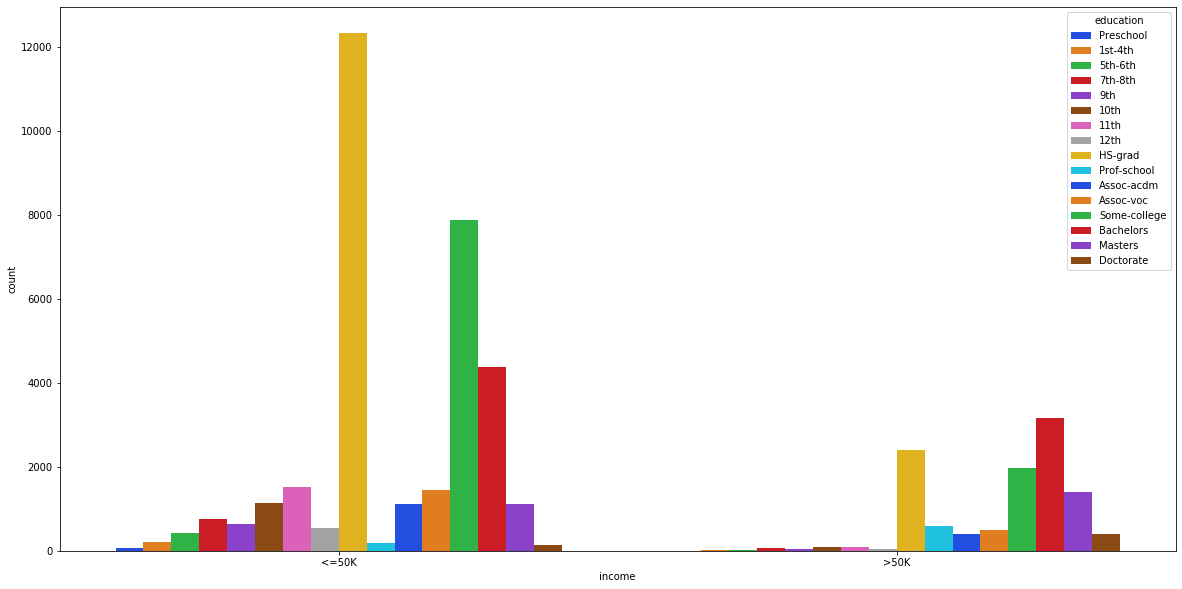

In [16]:
rcParams['figure.figsize'] = 20, 10
sns.countplot(x='income', hue='education', data = dataset, palette="bright");

- Risulta evidente il trend che le persone con l'income superiore alla soglia hanno quasi sempre l'istruzione superiore alla scuola superiore.

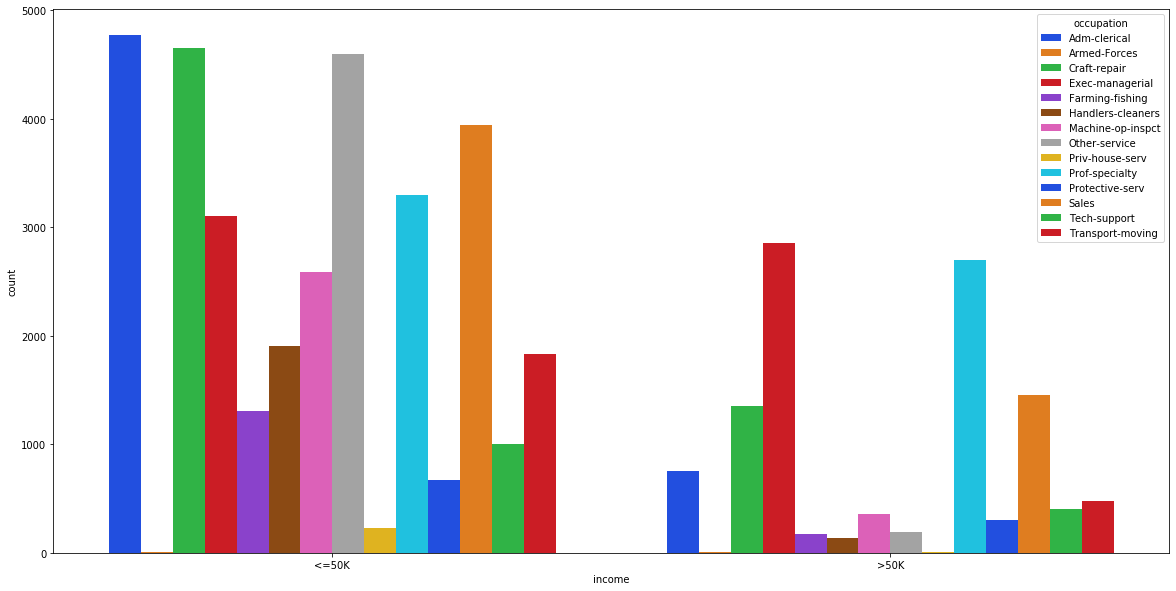

In [17]:
rcParams['figure.figsize'] = 20, 10
sns.countplot(x='income', hue='occupation', data = dataset, palette="bright")

- Risulta evidente che i due lavori piu' redditizi sono Exec-management e prof-speciality

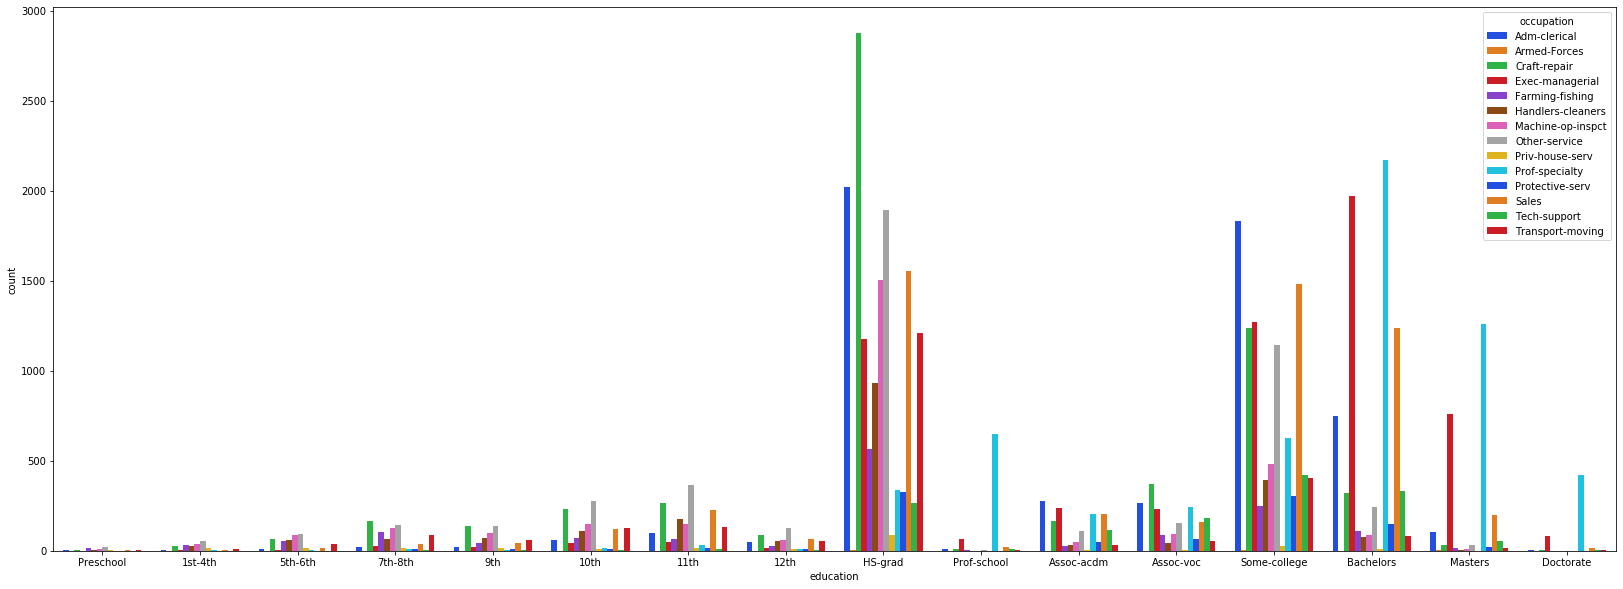

In [18]:
rcParams['figure.figsize'] = 28, 10
sns.countplot(x='education', hue='occupation', data = dataset, palette="bright")

- Si puo' osservare che  la maggior parte delle persone con diploma della scuola superiore lavora nel settore craft-repair, seguito da lavoro da impiegato, mentre le persone con almeno la laurea lavorano principalmente nei settori specializzati

# Feature Engineering

- Il dataset in considerazione presenta un numero elevato di valori distinti per le categorie

- Prendendo in considerazione la distribuzione sbilanciata di alcune categorie, si potrebbero 'appiattire' le categorie prima di trasformarle nelle variabili binarie

- La categoria workclass potrebbe essere ragruppata in {private, self-employed, government, no_pay}

In [19]:
mapping = {
    "Private": "Private",
    "Self-emp-not-inc": "Self-employed",
    "Local-gov": "Government",
    "State-gov": "Government",
    "Self-emp-inc": "Self-employed",
    "Federal-gov": "Government",
    "Without-pay": "No_pay",
    "Never-worked": "No_pay"
}
dataset['workclass'] = dataset['workclass'].map(mapping).astype("category")

- La categoria education potrebbe essere raggruppata in {pre-HS, HS-grad (incluso some college), prof-school, assoc, bachelors, masters, doctorate}

In [20]:
mapping = {
    "HS-grad": "HS-grad",
    "Some-college": "HS-grad",
    "Bachelors": "Bachelors",
    "Masters": "Masters",
    "Assoc-voc": "Assoc",
    "11th": "Pre-HS",
    "Assoc-acdm": "Assoc",
    "10th": "Pre-HS",
    "7th-8th": "Pre-HS",
    "Prof-school": "Prof-school",
    "9th": "Pre-HS",
    "12th": "Pre-HS",
    "Doctorate": "Doctorate",
    "5th-6th": "Pre-HS",
    "1st-4th": "Pre-HS",
    "Preschool": "Pre-HS"
}
dataset['education'] = dataset['education'].map(mapping).astype("category")
dataset['education'].cat.reorder_categories(['Pre-HS', 'HS-grad', 'Prof-school', 'Assoc',
                                             'Bachelors', 'Masters', 'Doctorate'], inplace=True)

- La categoria marital-status potrebbe essere raggruppata in {married, single}

In [21]:
mapping = {
    "Married-civ-spouse": "Married",
    "Never-married": "Single",
    "Divorced": "Single",
    "Separated": "Single",
    "Widowed": "Single",
    "Married-spouse-absent": "Married",
    "Married-AF-spouse": "Married"
}
dataset['marital-status'] = dataset['marital-status'].map(mapping).astype("category")

- La categoria occupation potrebbe essere divisa in {adm-clerical, service, prof-speciality, sales, blue-collar, white-collar, other}

In [22]:
mapping = {
    "Craft-repair": "Blue-collar",
    "Prof-speciality": "Prof-speciality",
    "Exec-managerial": "White-collar",
    "Adm-clerical": "Adm-clerical",
    "Sales": "Sales",
    "Other-service": "Other",
    "Machine-op-inspct": "Blue-collar",
    "Transport-moving": "Blue-collar",
    "Handlers-cleaners": "Blue-collar",
    "Farming-fishing": "Blue-collar",
    "Tech-support": "Other",
    "Protective-serv": "Service",
    "Priv-house-serv": "Service",
    "Armed-Forces": "Other"
}
dataset['occupation'] = dataset['occupation'].map(mapping).astype("category")

- La categoria native-country potrebbe essere divisa in {US, Mexico, Central-America, North-America, Europe, South-America, Asia, Other}

In [23]:
mapping = {
    "United-States": "United-States",
    "Mexico": "Mexico",
    "Philippines": "Asia",
    "Germany": "Europe",
    "Puerto-Rico": "Central-America",
    "Canada": "North-America",
    "El-Salvador": "Central-America",
    "India": "Asia",
    "Cuba": "Central-America",
    "England": "Europe",
    "China": "Asia",
    "Jamaica": "Central-America",
    "South": "Europe",
    "Italy": "Europe",
    "Dominican-Republic": "Central-America",
    "Japan": "Asia",
    "Guatemala": "Central-America",
    "Vietnam": "Asia",
    "Columbia": "South-America",
    "Poland": "Europe",
    "Haiti": "Central-America",
    "Portugal": "Europe",
    "Iran": "Other",
    "Taiwan": "Asia",
    "Greece": "Europe",
    "Nicaragua": "Central-America",
    "Peru": "South-America",
    "Ecuador": "South-America",
    "Ireland": "Europe",
    "France": "Europe",
    "Thailand": "Asia",
    "Hong": "Asia",
    "Cambodia": "Asia",
    "Trinidad&Tobago": "Central-America",
    "Yugoslavia": "Other",
    "Outlying-US(Guam-USVI-etc)": "Other",
    "Laos": "Asia",
    "Scotland": "Europe",
    "Honduras": "Central-America",
    "Hungary": "Europe",
    "Holand-Netherlands": "Europe"
}
dataset['native-country'] = dataset['native-country'].map(mapping).astype("category")

- Infine, considerando la distribuzione dei valori continui capital gain e capital loss, si potrebbe trasformarli nelle variabili categoriche con valori capital-gain {none, low (0 < x < 13170), high ( >= 13170)} e capital-loss {none, low (0 < x < 1872), high ( >= 1872)}

In [24]:
dataset['capital-gain'] = [class_val(g, 13170) for g in dataset['capital-gain']]
dataset['capital-loss'] = [class_val(g, 1872) for g in dataset['capital-loss']]

dataset['capital-gain'] = dataset['capital-gain'].astype("category")
dataset['capital-loss'] = dataset['capital-loss'].astype("category")

dataset['capital-gain'].cat.reorder_categories(['None', 'Low', 'High'], inplace=True)

dataset['capital-loss'].cat.reorder_categories(['None', 'Low', 'High'], inplace=True)

- Si procede con la trasformazione delle variabili categoriche

- Le variabili education, capital-gain e capital-loss hanno i valori progressivi e comparabili, percio' e' opportuno utilizzare label encoding

In [25]:
dataset['education'] = dataset['education'].cat.codes.astype(int)
dataset['capital-gain'] = dataset['capital-gain'].cat.codes.astype(int)
dataset['capital-loss'] = dataset['capital-loss'].cat.codes.astype(int)

- Mentre per le variabili workclass, occupation, relationship, race, sex, capital-gain, capital-loss e native-country e' opportuno utilizzare One Hot Encoding

In [26]:
convert_cats = ["workclass", "occupation", "relationship", "race", "native-country"]
dataset = pd.get_dummies(dataset, columns=convert_cats, prefix=convert_cats)

- Per ridurre il numero di categorie, sex e marital-status sono resi binari

In [27]:
dataset['sex'] = dataset['sex'].map({"Male": 0, "Female":1}).astype(int)
dataset['marital-status'] = dataset['marital-status'].map({"Single": 0, "Married":1}).astype(int)

- Infine si rende binaria la variabile da predire

In [28]:
dataset['income'] = dataset['income'].map({"<=50K" : 0, ">50K": 1}).astype(int)

- Si puo' procedere alla visualizzazione della correlazione

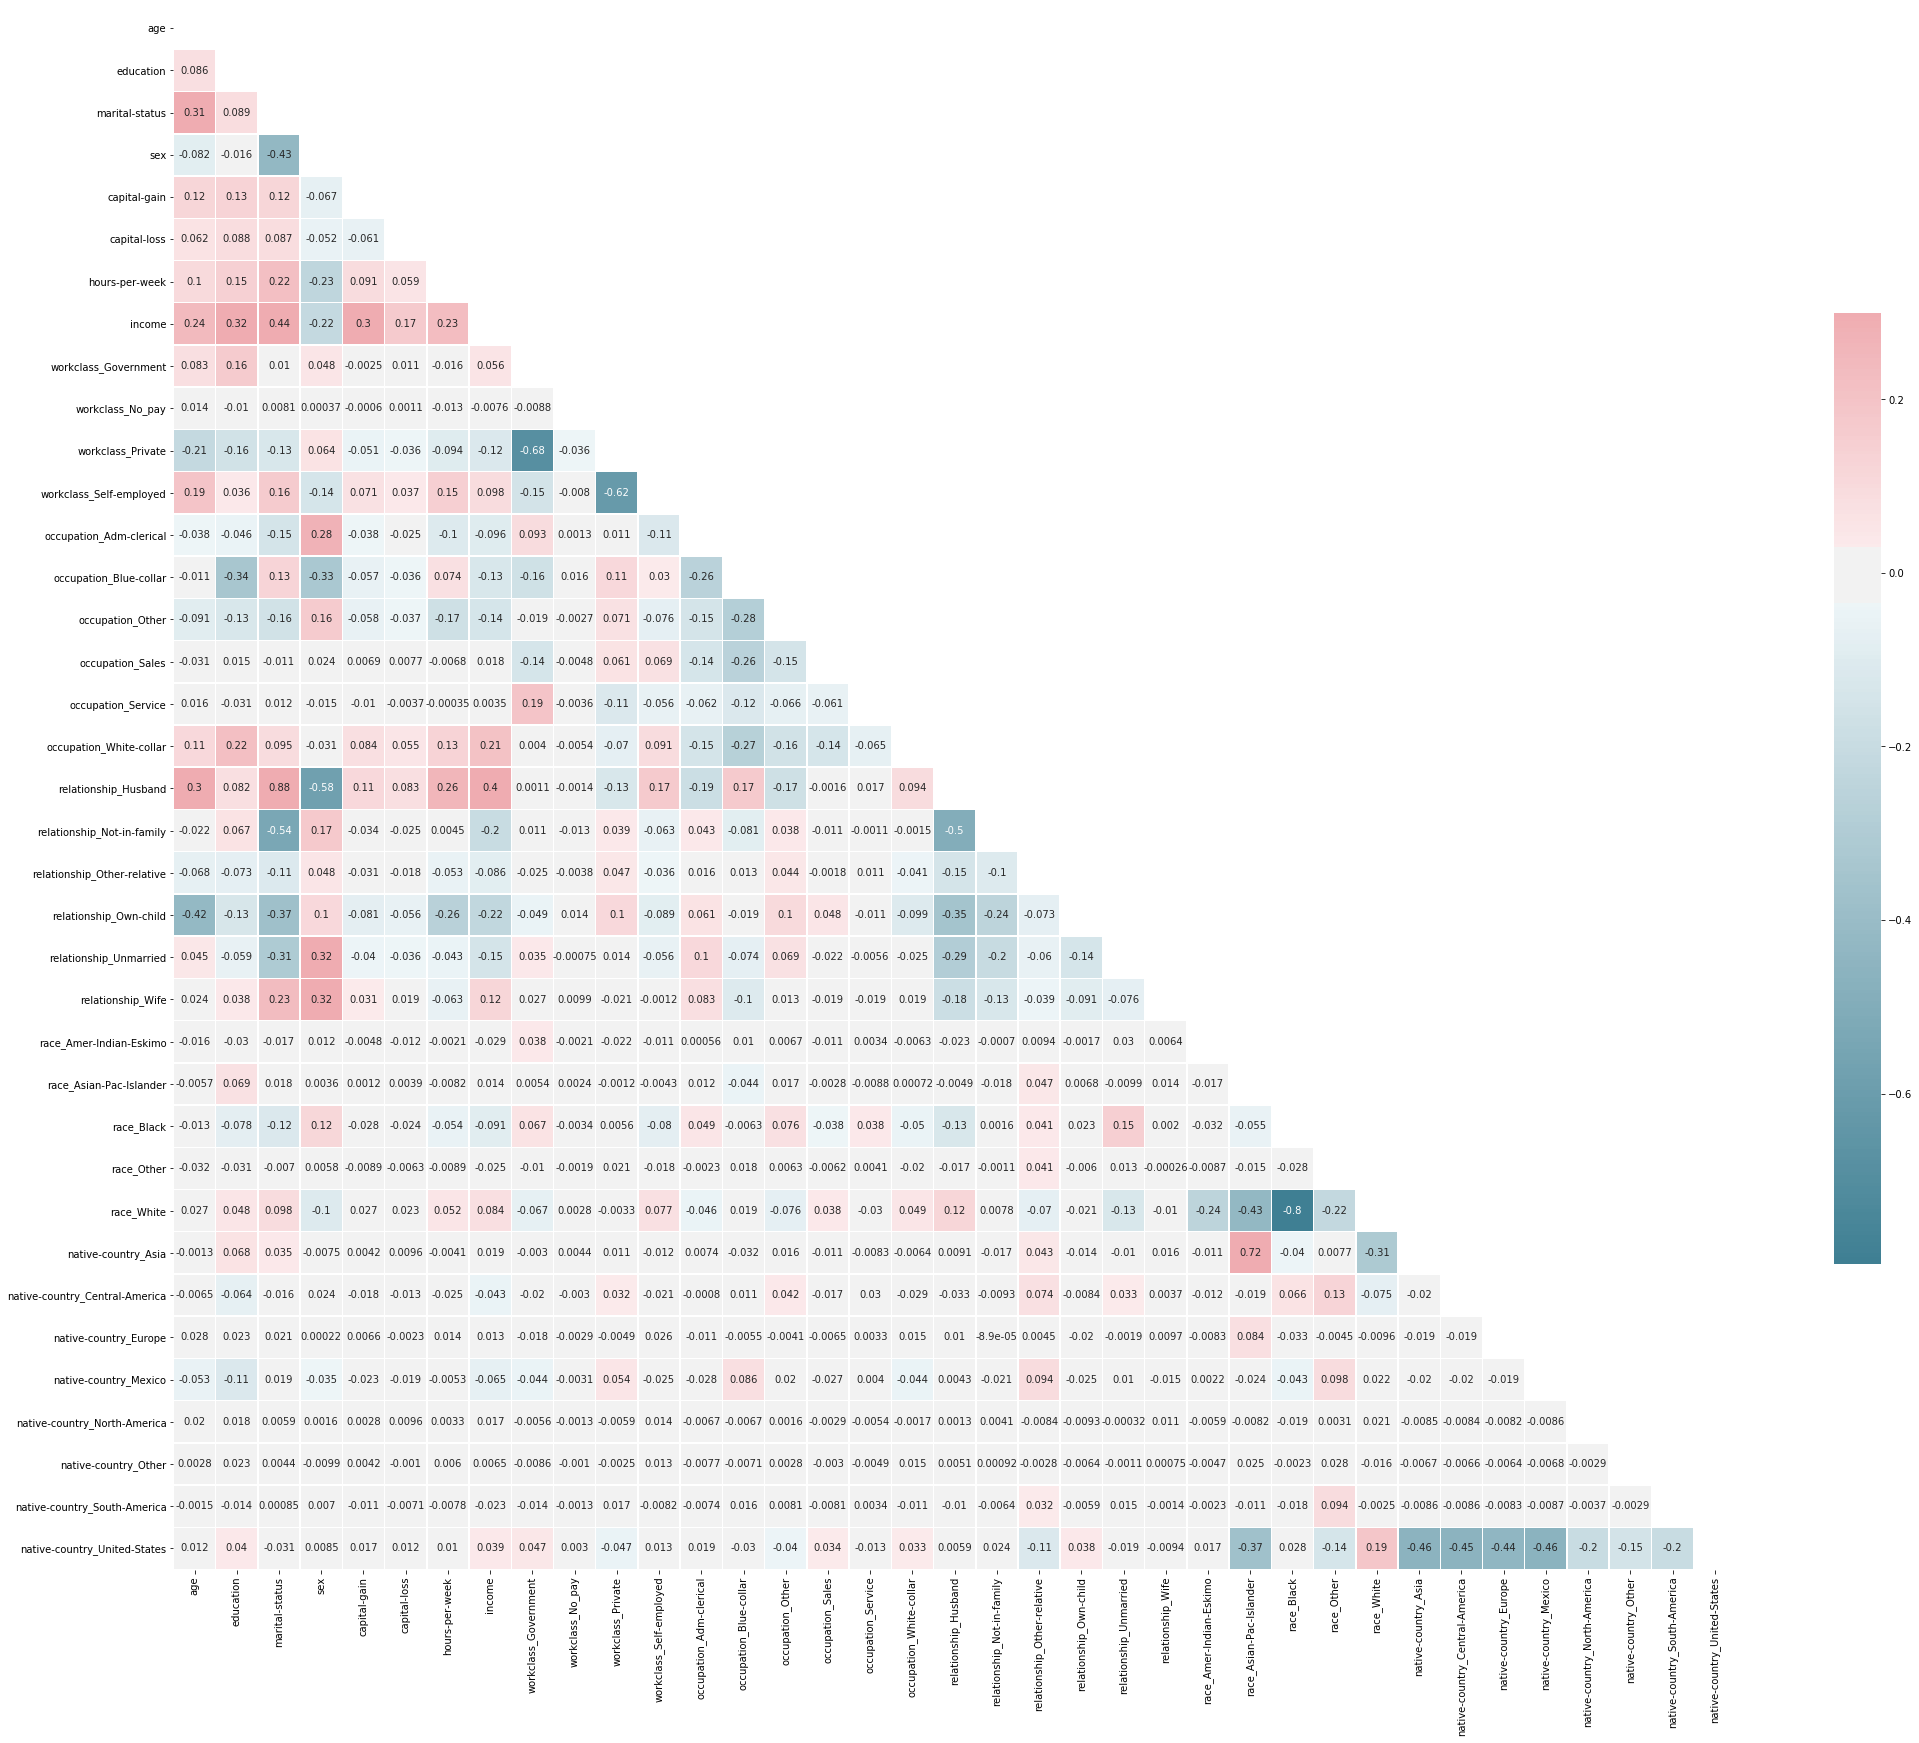

In [29]:
plot_correlation(dataset.corr(), 35, 35)

- Si puo' osservare che l'income e' correlato con l'eta', l'istuzione, il guadagno del capitale, le ore lavorative settimanali e lo stato civile.

- Si divide la data in train e test set

In [30]:
X = dataset.drop('income', axis=1)
y = dataset['income']

X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.25, random_state=17, stratify=y.values)

# Perceptron

- Si cercano gli iperparametri migliori tramite grid search

In [31]:
perceptron = Pipeline([
    ('std', None),
    ('perceptron', Perceptron(max_iter=2000, tol=1e-3, early_stopping=True, n_jobs=-1, random_state=42))
])

parameters = {
    'std': [None, StandardScaler()],
    'perceptron__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'perceptron__alpha': np.logspace(-3, 3, 7),
}

perceptron_grid_cv = GridSearchCV(perceptron, parameters, cv=5, n_jobs=-1, scoring='f1')
perceptron_grid_cv.fit(X_train, y_train)

print('Grid Best parameters:', perceptron_grid_cv.best_params_)

Grid Best parameters: {'perceptron__alpha': 0.001, 'perceptron__penalty': 'l2', 'std': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [32]:
print_c_i(perceptron_grid_cv)

Interval with confidence 95%: 
lower = 0.5829
upper = 0.6011


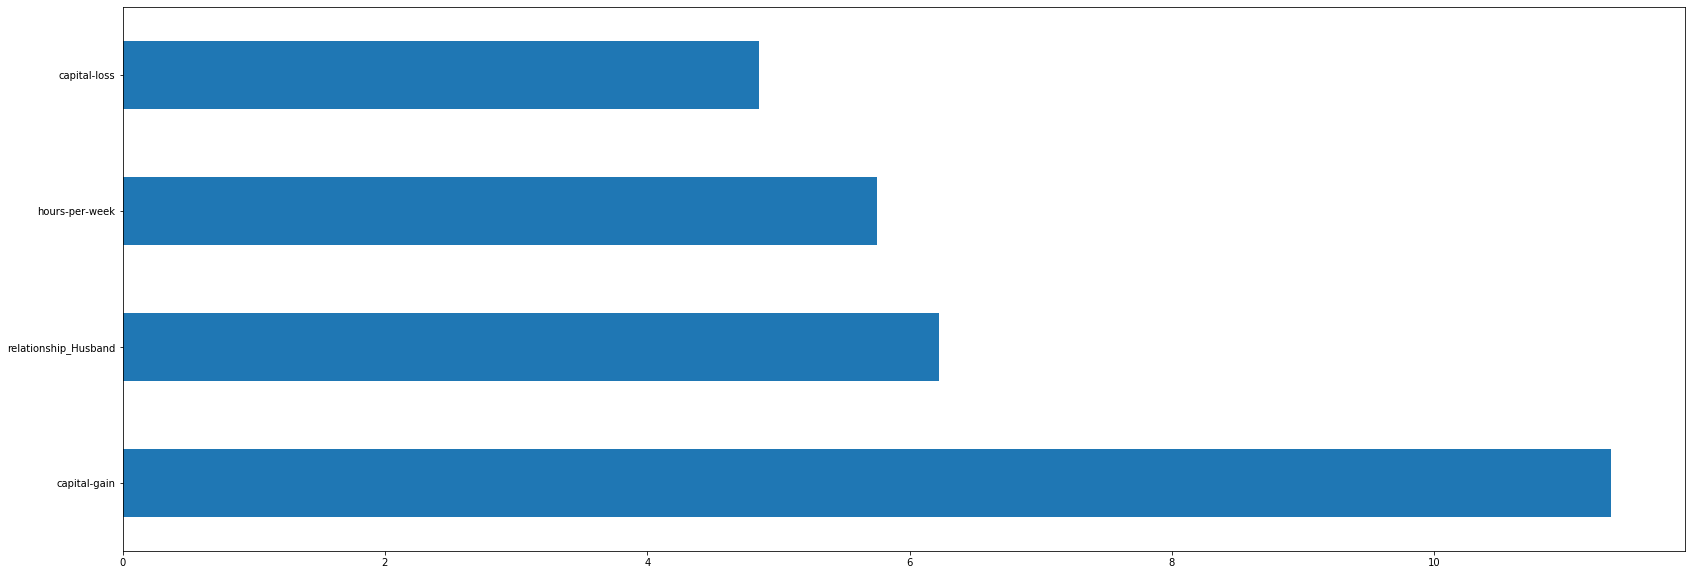

In [33]:
plot_best_feats(perceptron_grid_cv, 1)

- Possiamo osservare che le feature piu' rilevanti sono il guadagno e essere marito. 

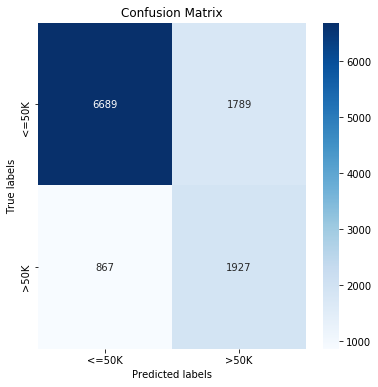

In [34]:
plot_confusion(perceptron_grid_cv)

In [35]:
pred = perceptron_grid_cv.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
print(pd.Series(perceptron_grid_cv.best_estimator_[1].coef_[0], index=X_train.columns))

Accuracy: 0.7643718949609652
              precision    recall  f1-score   support

           0       0.89      0.79      0.83      8478
           1       0.52      0.69      0.59      2794

    accuracy                           0.76     11272
   macro avg       0.70      0.74      0.71     11272
weighted avg       0.79      0.76      0.77     11272

age                                0.795905
education                          4.188123
marital-status                     1.079789
sex                               -5.481217
capital-gain                      11.343814
capital-loss                       4.853672
hours-per-week                     5.748946
workclass_Government              -0.569481
workclass_No_pay                  -0.782925
workclass_Private                 -0.974794
workclass_Self-employed            1.984804
occupation_Adm-clerical           -1.293304
occupation_Blue-collar             0.568179
occupation_Other                  -3.018315
occupation_Sales            

# Perceptron with Poly Features

- Si considera di provare a polinomizzare le variabili per vedere se si possa ottenere un modello migliore

In [36]:
poly_perceptron = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('std', None),
    ('perceptron', Perceptron(max_iter=2000, tol=1e-3, early_stopping=True, n_jobs=-1))
])

parameters = {
    'std': [None, StandardScaler()],
    'perceptron__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'perceptron__alpha': [0.0001, 0.001, 0.01, 0.1, 1],
}

poly_perceptron_cv = GridSearchCV(poly_perceptron, parameters, cv=5, n_jobs=-1, return_train_score=True, scoring='f1')
poly_perceptron_cv.fit(X_train, y_train)

print('Best parameters:', perceptron_grid_cv.best_params_)

Best parameters: {'perceptron__alpha': 0.001, 'perceptron__penalty': 'l2', 'std': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [37]:
print_c_i(poly_perceptron_cv)

Interval with confidence 95%: 
lower = 0.6519
upper = 0.6694


In [38]:
poly_feats = pd.Series(poly_perceptron_cv.best_estimator_[2].coef_[0])
poly_names = pd.Series(poly_perceptron_cv.best_estimator_[0].get_feature_names(dataset.drop('income', axis=1).columns))
poly_d = {
    'name' : poly_names,
    'value': poly_feats
}
print(pd.DataFrame(poly_d).sort_values('value', ascending=False).head(5))
print(pd.DataFrame(poly_d).sort_values('value', ascending=False).tail(5))

                              name      value
177    capital-gain hours-per-week  81002.552
41                age capital-gain  80965.552
39              age marital-status  51131.552
59           age relationship_Wife  43469.552
112  marital-status hours-per-week  40713.552
                                      name      value
50                    age occupation_Other -39986.552
252  hours-per-week relationship_Own-child -42419.552
244  hours-per-week occupation_Blue-collar -51635.552
1                                      age -54613.552
7                           hours-per-week -75239.552


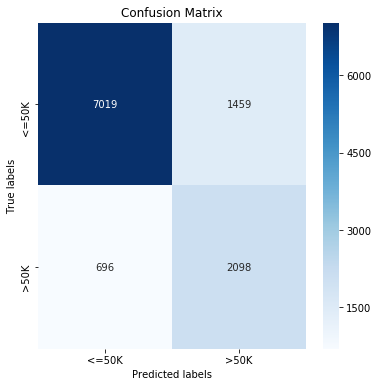

In [39]:
plot_confusion(poly_perceptron_cv)

In [40]:
pred = poly_perceptron_cv.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))

Accuracy: 0.8088183108587651
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      8478
           1       0.59      0.75      0.66      2794

    accuracy                           0.81     11272
   macro avg       0.75      0.79      0.76     11272
weighted avg       0.83      0.81      0.82     11272



# Logistic Regression

- Si considera la regressione logistica

In [41]:
std_logreg = Pipeline([
    ('std', None),
    ('lr', LogisticRegression())
])

parameters = {
    'std': [None, StandardScaler()],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'lr__solver': ['liblinear']
}

logreg_grid_cv = GridSearchCV(std_logreg, parameters, cv=5, n_jobs=-1, return_train_score=True, scoring='f1')
logreg_grid_cv.fit(X_train, y_train)

print('Best parameters:', logreg_grid_cv.best_params_)

Best parameters: {'lr__C': 0.001, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'std': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [42]:
print_c_i(logreg_grid_cv)

Interval with confidence 95%: 
lower = 0.6316
upper = 0.6493


In [43]:
feats = pd.Series(logreg_grid_cv.best_estimator_[1].coef_[0])
names = pd.Series(dataset.drop('income', axis=1).columns)
d = {
    'name' : names,
    'value': feats
}
print(pd.DataFrame(d).sort_values('value', ascending=False).head(5))
print(pd.DataFrame(d).sort_values('value', ascending=False).tail(5))

                    name     value
4           capital-gain  0.450047
1              education  0.410074
2         marital-status  0.343872
17  relationship_Husband  0.273462
6         hours-per-week  0.237203
                          name     value
13            occupation_Other -0.156814
18  relationship_Not-in-family -0.157247
3                          sex -0.177697
20      relationship_Own-child -0.179416
12      occupation_Blue-collar -0.261859


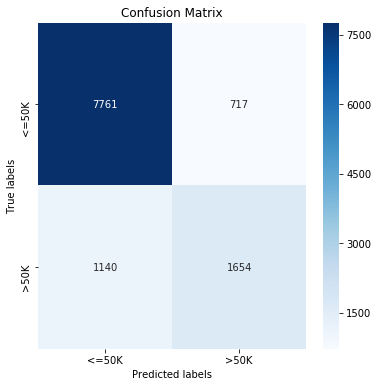

In [44]:
plot_confusion(logreg_grid_cv)

In [45]:
pred = logreg_grid_cv.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))

Accuracy: 0.8352555003548616
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      8478
           1       0.70      0.59      0.64      2794

    accuracy                           0.84     11272
   macro avg       0.78      0.75      0.77     11272
weighted avg       0.83      0.84      0.83     11272



# SVM

In [46]:
std_svm = Pipeline([
    ('std', StandardScaler()),
    ('svm', SVC())
])

parameters = {
    'svm__kernel': ['rbf'],
    'svm__C': [0.01, 0.1, 1, 10, 100],
}

svm_grid_cv = GridSearchCV(std_svm, parameters, cv=3, n_jobs=-1, return_train_score=True, scoring='f1')
svm_grid_cv.fit(X_train, y_train)

print('Best parameters:', svm_grid_cv.best_params_)

Best parameters: {'svm__C': 10, 'svm__kernel': 'rbf'}


In [47]:
print_c_i(svm_grid_cv)

Interval with confidence 95%: 
lower = 0.6301
upper = 0.6478


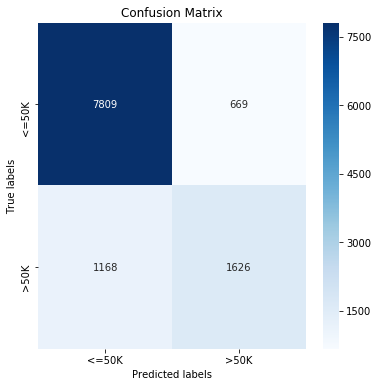

In [48]:
plot_confusion(svm_grid_cv)

In [49]:
pred = svm_grid_cv.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))

Accuracy: 0.8370298083747338
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      8478
           1       0.71      0.58      0.64      2794

    accuracy                           0.84     11272
   macro avg       0.79      0.75      0.77     11272
weighted avg       0.83      0.84      0.83     11272



# Confronto Modelli

- Vogliamo confrontare i modelli utilizzando gli intervalli di confidenza

## Perceptron vs Casuale

In [50]:
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(X, y)

print('Dummy Score: {}'.format(dummy_model.score(X_test, y_test)))
print(model_diff_interval(perceptron_grid_cv, dummy_model, X_test, y_test))

Dummy Score: 0.5074520936834634
(0.07960190331808956, 0.1054872590667986)


- Allenando perceptron si ottiene un modello superiore rispetto a un modello casuale uniforme

## Perceptron vs Poly Preceptron

In [51]:
print(model_diff_interval(perceptron_grid_cv, poly_perceptron_cv, X_test, y_test))

(0.05607289636829757, 0.08126923996205995)


- Le feature polinomiali hanno migliorato il modello

## Poly Perceptron vs Logistical

In [52]:
print(model_diff_interval(poly_perceptron_cv, logreg_grid_cv, X_test, y_test))

(0.007773805259997043, 0.032663576600730715)


## Poly Perceptron vs SVM

In [53]:
print(model_diff_interval(poly_perceptron_cv, svm_grid_cv, X_test, y_test))

(0.009207615667770593, 0.03410840065252954)


## SVM vs Logistical

In [54]:
print(model_diff_interval(svm_grid_cv, logreg_grid_cv, X_test, y_test))

(-0.01109413088771563, 0.013972765347288002)


- La differenza tra questi modelli non e' statisticamente rilevante.

# Scelta del modello migliore

- Si costruisce una tabella per i valori delle valutazioni f1 e accuracy

In [55]:
d = {
    'f1': [f1_score(y_test, perceptron_grid_cv.predict(X_test)), f1_score(y_test, poly_perceptron_cv.predict(X_test)), 
          f1_score(y_test, logreg_grid_cv.predict(X_test)), f1_score(y_test, svm_grid_cv.predict(X_test))],
    'accuracy': [accuracy_score(y_test,  perceptron_grid_cv.predict(X_test)), accuracy_score(y_test, poly_perceptron_cv.predict(X_test)),
                 accuracy_score(y_test, logreg_grid_cv.predict(X_test)),accuracy_score(y_test, svm_grid_cv.predict(X_test))]
}
pd.DataFrame(d, index=['Perceptron', 'Perceptron Poly', 'RegLog', 'SVM']).sort_values(by='f1', ascending = False)

f1  accuracy
Perceptron Poly  0.660683  0.808818
RegLog           0.640465  0.835256
SVM              0.639025  0.837030
Perceptron       0.592012  0.764372

- Avendo un dataset con distribuzione di casi abbastanza sbilanciata, si preferisce avere score f1 alto.
- Per questo motivo il modello migliore risulta essere Perceptron con feature Polinomiali, sebbene non abbia l'accuracy migliore.


# Interpretazione Coefficienti

- Si analizzano i coefficienti del modello migliore

In [56]:
print(pd.DataFrame(poly_d).sort_values('value', ascending=False).head(5))
print(pd.DataFrame(poly_d).sort_values('value', ascending=False).tail(5))

                              name      value
177    capital-gain hours-per-week  81002.552
41                age capital-gain  80965.552
39              age marital-status  51131.552
59           age relationship_Wife  43469.552
112  marital-status hours-per-week  40713.552
                                      name      value
50                    age occupation_Other -39986.552
252  hours-per-week relationship_Own-child -42419.552
244  hours-per-week occupation_Blue-collar -51635.552
1                                      age -54613.552
7                           hours-per-week -75239.552


- Osserviamo che i coefficienti piu' correlati positivamente sono la combinazione del guadagno del capitale, ore lavorative, eta', stato civile.

- Invece i coefficienti piu' correlati negativamente sono la combinazione di fattori quali eta', occupazione, ore lavorative, composizione familiare.
